# PCA on Sea-Level Pressure Data

In [1]:
from __future__ import division

%matplotlib inline

from IPython.display import display 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
from sklearn.decomposition import PCA
import sys
import xarray as xr

sys.path.append('../src/')
import utils

mpl.rcParams['legend.fontsize'] = 'small'

In [2]:
mat = sio.loadmat('slp_vars_from_matlab.mat')

In [3]:
VAR0 = mat['VAR0']
coords = {'incrop' : mat['incrop'].ravel(),
          'Nx' : int(mat['Nx']), 'Ny' : int(mat['Ny']), 
          'x_NARR' : mat['x_NARR'].ravel(), 
          'y_NARR' : mat['y_NARR'].ravel(),
          'x_coast' : mat['xx_coast_NARR'].ravel(),
          'y_coast' : mat['yy_coast_NARR'].ravel(),
          'x_domain' : mat['x_dom'].ravel(), 
          'y_domain' : mat['y_dom'].ravel()}

In [4]:
def get_var(var_in, coords):
    Nx, Ny = coords['Nx'], coords['Ny']
    var = np.nan * np.ones(Nx * Ny)
    var[coords['incrop']] = var_in
    var = var.reshape((Nx, Ny), order='F')
    X = coords['x_NARR'].reshape((Nx, Ny), order='F')
    Y = coords['y_NARR'].reshape((Nx, Ny), order='F')
    xrcoords = {'X' : xr.DataArray(X, dims=['iy', 'ix']),
                'Y' : xr.DataArray(Y, dims=['iy', 'ix'])}

    return xr.DataArray(var, dims=['iy', 'ix'], coords=xrcoords)

In [32]:
def plot_var(var, coords, climits=None, ticks=False, axis=False):
    vals = np.ma.masked_array(var.values, np.isnan(var.values))
    plt.pcolor(var['X'].T, var['Y'].T, vals.T, cmap='jet')
    plt.plot(coords['x_coast'], coords['y_coast'], 'k')
    plt.plot(coords['x_domain'], coords['y_domain'], '-.', color='0.6')
    if climits is not None:
        plt.clim(climits)
    if not ticks:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    if not axis:
        plt.gca().axis('off')

In [33]:
var1 = get_var(VAR0[::, 0], coords)

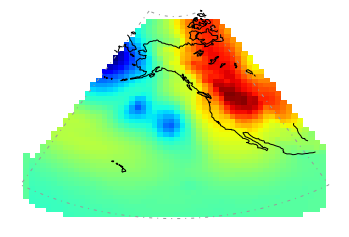

In [34]:
plot_var(var1, coords)

Plot SLP over the whole domain for the first 30 days of Jan 1979

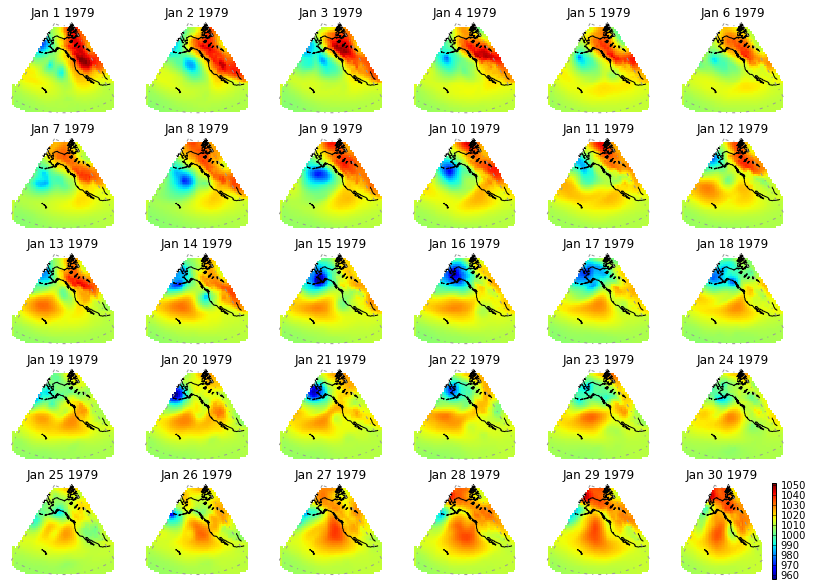

In [35]:
data_sub = VAR0[:, :30]
cmin = np.nanmin(data_sub)
cmax = np.nanmax(data_sub)
nr, nc = 5, 6

fig, axes = plt.subplots(5, 6, figsize=(14, 10))
for i, ax in enumerate(axes.ravel()):
    plt.sca(ax)
    var = get_var(VAR0[:, i], coords)
    plot_var(var, coords, climits=(cmin, cmax))
    plt.title('Jan %d 1979' % (i + 1))
plt.colorbar()

### Principal Component Analysis

Take the transpose of the data matrix, so that the rows are the daily measurements and the columns are the grid points

In [9]:
data = VAR0.T
data.shape

(11688L, 1741L)

In [13]:
kmax = 10
pca = utils.princomp(data, kmax=kmax)
eigval, eigvec, PCs = pca['eigval'], pca['eigvec'], pca['scores']

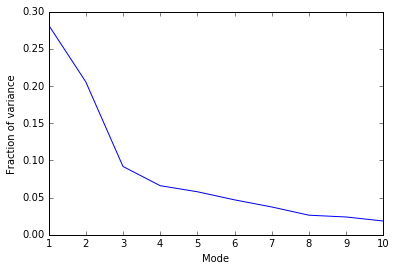

In [27]:
plt.plot(range(1, len(pca['varfrac']) + 1), pca['varfrac'])
plt.xlabel('Mode')
plt.ylabel('Fraction of variance')

In [17]:
# set the time series (in years)
time = np.arange(1979, 2011, 1/365.25)
time.shape

(11688L,)

In [42]:
# separate indices for winter and summer (just so that in the plots
# they are better visualized
indicesw, indicess = mat['indicesw'].ravel(), mat['indicess'].ravel()
PCs_winter, PCs_summer = np.nan * PCs, np.nan * PCs
PCs_winter[indicesw] = PCs[indicesw]
PCs_summer[indicess] = PCs[indicess]

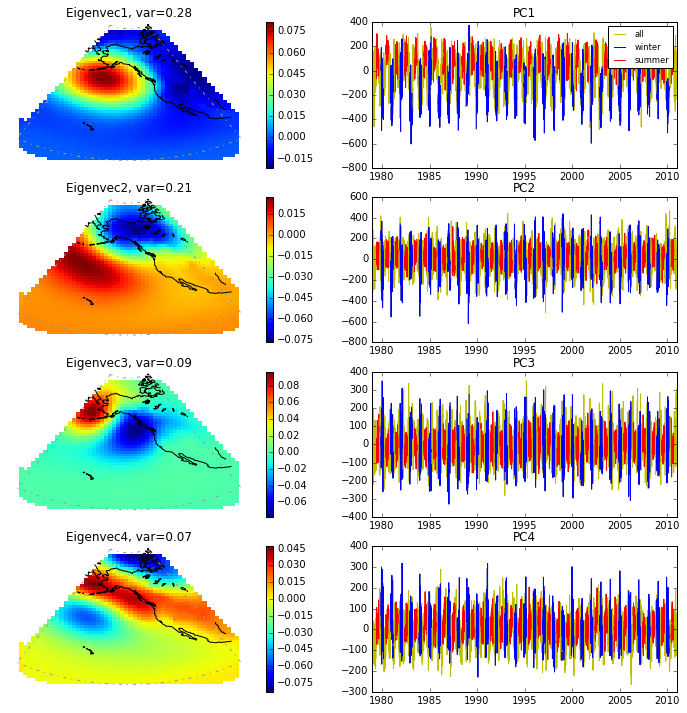

In [44]:
# Plot first 4 eigenvectors and PCs
nr, nc = 4, 2
iplot = 1
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(nr, nc, iplot)
    var = get_var(eigvec[i], coords)
    plot_var(var, coords)
    plt.colorbar()
    plt.title('Eigenvec%d, var=%.2f' % (i + 1, pca['varfrac'][i]))
    iplot += 1
    plt.subplot(nr, nc, iplot)
    plt.plot(time, PCs[:, i], 'y', label='all')
    plt.plot(time, PCs_winter[:, i], 'b', label='winter')
    plt.plot(time, PCs_summer[:, i], 'r', label='summer')
    plt.xlim(min(time), max(time))
    plt.title('PC%d' % (i + 1))
    if i == 0:
        plt.legend()
    iplot += 1

(-800, 800)

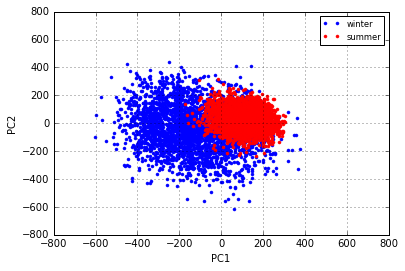

In [49]:
# plot data in space of the two first two PCs
plt.plot(PCs[indicesw, 0], PCs[indicesw, 1], 'b.', label='winter')
plt.plot(PCs[indicess, 0], PCs[indicess, 1], 'r.', label='summer')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.xlim(-800, 800)
plt.ylim(-800, 800)